In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [30]:
from IPython import get_ipython
import pandas as pd
pd.set_option('float_format', '{:.2f}'.format)
import pandas_profiling as pp
import numpy as np
import scipy
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
# Load models
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

In [31]:
# Source: https://www.kaggle.com/mlg-ulb/creditcardfraud
df = pd.read_csv("./creditcard.csv") 
# Drop duplicated?
df = df.drop_duplicates()

Top Absolute Correlations
V2    Amount   0.53
Time  V3       0.42
V7    Amount   0.40
V5    Amount   0.39
V20   Amount   0.34
V17   Class    0.31
V14   Class    0.29
V12   Class    0.25
Time  V11      0.25
      V25      0.23
V1    Amount   0.23
V6    Amount   0.22
V3    Amount   0.21
V10   Class    0.21
V16   Class    0.19
Time  V15      0.18
V3    Class    0.18
Time  V5       0.17
V7    Class    0.17
V11   Class    0.15
Time  V22      0.14
V4    Class    0.13
Time  V12      0.13
      V1       0.12
V23   Amount   0.11
V21   Amount   0.11
Time  V4       0.11
V18   Class    0.11
V8    Amount   0.10
V10   Amount   0.10


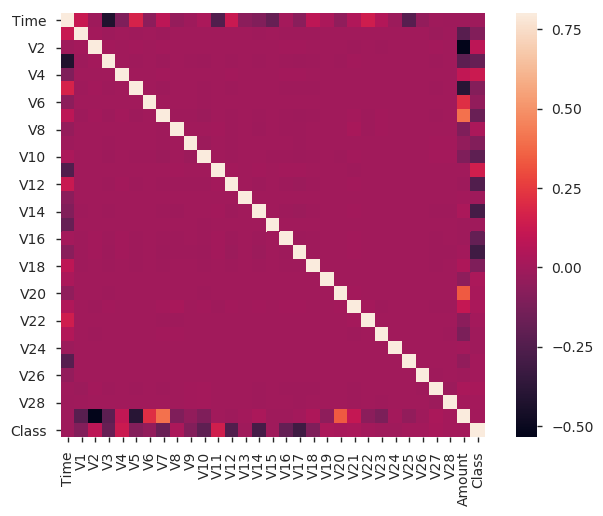

<Figure size 1600x1600 with 0 Axes>

In [33]:
# Correlation
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 30).to_string())

sns.heatmap(df.corr(), vmax=.8, square=True)
plt.figure(figsize=(16, 16))
plt.show()

 #### Findings
 1. Time, Amount and Class has some correlation with Vxx
 2. Multicollinearity is low
 3. High class imbalance

 #### Our key evaluation metric to optimize on is recall
 * For fraud prevention is more important to capture false negatives than false positives
 * It is ok to predict an instance as fraud but it is not, because there is no direct money loss for the bank and customer
 * On the other hand, it is NOT ok to label an instance as NOT fraud, but it was. There is direct money loss for the customer

 #### Models to try:
 1. LogisticRegression
 2. RandomForestClassifier
 3. KNN
 4. Support Vector Machine
 5. GradientBoostingClassifier

In [34]:
mm_scaler = MinMaxScaler()
df[['Time']] = mm_scaler.fit_transform(df[['Time']].values)
df[['Amount']] = mm_scaler.fit_transform(df[['Amount']].values)

X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [35]:
# Logistic Regression: 
lr = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)

# Fit the model.
fit = lr.fit(X_train, y_train)

# Display.
y_pred = fit.predict(X_test)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print('\nAUC: ', auc(fpr, tpr))
score = cross_val_score(fit, X, y, cv=5, scoring='recall')
print('\nRecall: ', score)
print("Cross Validated Recall: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


Confusion Matrix
 Predicted      0   1    All
True                       
0          56638  11  56649
1             35  62     97
All        56673  73  56746

AUC:  0.8194905397734976

Recall:  [0.76842105 0.65263158 0.37894737 0.64893617 0.4893617 ]
Cross Validated Recall: 0.59 (+/- 0.27)


In [36]:
# Random Forest: 
rfc = ensemble.RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 8, 16, 32, 64], 
              #'max_features': ['log2', 'sqrt','auto'], 
              #'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10, 13], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

''' 
Best Model so far:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)
'''

# Run the grid search
grid_obj = GridSearchCV(rfc, parameters, scoring='recall', cv=3, n_jobs=-1, verbose=1)
grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
rfc = grid_obj.best_estimator_


Fitting 3 folds for each of 225 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:  8.4min finished


In [37]:
# Run best model:
rfc = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

# Fit the best algorithm to the data. 
rfc.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of  64 | elapsed:    3.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    3.7s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [38]:
y_pred = rfc.predict(X_test)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('RFC:\n', classification_report(y_test, y_pred, target_names=['0', '1']))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print('AUC: ', auc(fpr, tpr))


[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done  58 out of  64 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=36)]: Done  64 out of  64 | elapsed:    0.0s finished


Confusion Matrix
 Predicted      0   1    All
True                       
0          56644   5  56649
1             18  79     97
All        56662  84  56746
RFC:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56649
           1       0.94      0.81      0.87        97

   micro avg       1.00      1.00      1.00     56746
   macro avg       0.97      0.91      0.94     56746
weighted avg       1.00      1.00      1.00     56746

AUC:  0.9071723634396873


In [39]:
score = cross_val_score(rfc, X, y, cv=10, scoring='recall', n_jobs=-1, verbose=1)
print("RFC: Input X --> Recall: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   38.9s remaining:   38.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   39.4s finished


RFC: Input X --> Recall: 0.725 (+/- 0.304)


In [40]:
# KNN:
# for k in range(4, 40, 1):
k = 19
neighbors = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, weights='distance')
neighbors.fit(X_train, y_train)
y_pred = neighbors.predict(X_test)
print('k = ', k)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('KNN:\n', classification_report(y_test, y_pred, target_names=['0', '1']))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print('AUC: ', auc(fpr, tpr))
# Cross Validation
score = cross_val_score(neighbors, X_test, y_test, cv=5, scoring='recall', n_jobs=-1)
print("KNN: Input X --> Recall: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))


k =  19
Confusion Matrix
 Predicted      0   1    All
True                       
0          56644   5  56649
1             16  81     97
All        56660  86  56746
KNN:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56649
           1       0.94      0.84      0.89        97

   micro avg       1.00      1.00      1.00     56746
   macro avg       0.97      0.92      0.94     56746
weighted avg       1.00      1.00      1.00     56746

AUC:  0.9174816417902028
KNN: Input X --> Recall: 0.813 (+/- 0.113)


In [41]:
# SVM:
svc = SVC(gamma='scale')
score = cross_val_score(svc, X_train, y_train, cv=5, scoring='recall', n_jobs=-1, verbose=1)
print("Input X_train --> Recall: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))
## Recall: 0.000 (+/- 0.000) --> Not working

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished


Input X_train --> Recall: 0.636 (+/- 0.079)


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)
# Gradient Boosting
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance',
          'verbose': 1,
          'n_iter_no_change': 50, 
          'validation_fraction': 0.1}

# Initialize and fit the model.
gbc = ensemble.GradientBoostingClassifier(**params)
gbc.fit(X_train, y_train)

#predict_train = gbc.predict(X_train)
y_pred = gbc.predict(X_test)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('RFC:\n', classification_report(y_test, y_pred, target_names=['0', '1']))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print('AUC: ', auc(fpr, tpr))
# Best:
#              precision    recall  f1-score   support
#           0       1.00      1.00      1.00     28314
#           1       0.91      0.69      0.79        59

      Iter       Train Loss   Remaining Time 
         1           0.0324            4.91m
         2           0.0346            4.89m
         3           0.0293            4.88m
         4           0.0282            4.86m
         5           0.0263            4.85m
         6           0.0563            4.84m
         7 4826061054510876048350405172658176.0000            4.83m
         8 4826061054510876048350405172658176.0000            4.81m
         9 4826061054510876048350405172658176.0000            4.80m
        10 344755860793852018404177599056090663918130472650014720.0000            4.79m
        20 344755860793852018404177599056090663918130472650014720.0000            4.72m
        30 344755860793852018404177599056090663918130472650014720.0000            4.63m
        40 344755860793852018404177599056090663918130472650014720.0000            4.54m
        50 344755860793852018404177599056090663918130472650014720.0000            4.43m
        60 34475586079385201840417759905

In [43]:
score = cross_val_score(gbc, X, y, cv=10, scoring='recall', n_jobs=-1, verbose=1)
print("GradBoost: Input X --> Recall: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))
# Output> Recall: 0.456 (+/- 0.691) --> too much variance --> unstable results 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished


GradBoost: Input X --> Recall: 0.472 (+/- 0.607)


 #### Final model evaluation:
 The best model is the KNN with k = 19. This one has the best recall (0.81 on the test set).
 On top this model has the best f1 score. Cross-validation is much better than the 2nd best model, the RandomForestClassifier